In [1]:
import json
import torch
import numpy as np
from rdkit.Chem import AllChem
from rdkit import Chem
from transE_MLP import TransE
from tqdm import tqdm

In [2]:
model = TransE(n_templates=2990, device='cpu', hidden_sizes=[1024, 1024], output_dim=64).to('cpu')
# Load model.pth
model.load_state_dict(torch.load('output2/model.pth', map_location='cpu'))
model.eval()

TransE(
  (criterion): MarginRankingLoss()
  (relations_emb): Embedding(2990, 64)
  (layers): ModuleList(
    (0): Dense(
      (linear): Linear(in_features=2048, out_features=1024, bias=True)
      (hidden_act): ReLU()
    )
    (1): Dense(
      (linear): Linear(in_features=1024, out_features=64, bias=True)
      (hidden_act): ReLU()
    )
  )
  (dropout): Dropout(p=0.3, inplace=False)
)

In [3]:
all_embs = model.relations_emb(torch.tensor(np.arange(2990)).long())

In [4]:
# Load data/train_rxns_with_template.jsonl
with open('data/train_rxns_with_template_gen.jsonl', 'r') as f:
    train_rxns = [json.loads(line) for line in f]
# Load data/val_rxns_with_template.jsonl
with open('data/val_rxns_with_template_gen.jsonl', 'r') as f:
    val_rxns = [json.loads(line) for line in f]
# Load data/templates.jsonl
with open('data/templates_gen.jsonl', 'r') as f:
    templates = [json.loads(line) for line in f]

In [5]:
len(templates)

2990

In [6]:
template2idx = {template['reaction_smarts']: template['index'] for template in templates}

In [7]:
idx2class = {}
for rxn in train_rxns:
    rxn_class = rxn['class']
    idx = template2idx[rxn['canon_reaction_smarts']]
    if idx not in idx2class:
        idx2class[idx] = [rxn_class]
    else:
        idx2class[idx].append(rxn_class)

for idx in idx2class:
    idx2class[idx] = max(idx2class[idx], key=idx2class[idx].count)

class2color = {
    '1': '#FF3355',
    '2': '#22AAFF',
    '3': '#33FFAA',
    '4': '#EE22EE',
    '5': '#FFAA22',
    '6': '#FFCC55',
    '7': '#FFAACC',
    '8': '#555555',
    '9': '#33CC11',
    '10': '#1155CC',
}

In [8]:
from umap import UMAP
import matplotlib.pyplot as plt

umap = UMAP(n_components=2)
embs = umap.fit_transform(all_embs.detach().numpy())

/home/kyu3/miniconda3/envs/retro-kg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


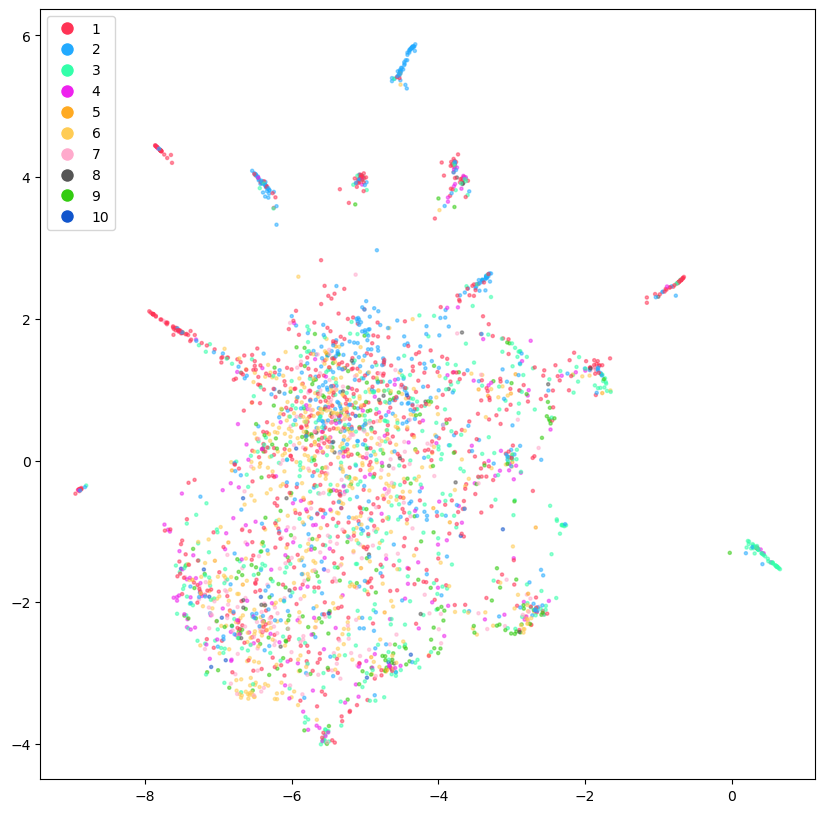

In [9]:
# Create empty lists to store coordinates and colors
x_coords = []
y_coords = []
colors = []

# Iterate over embeddings and store coordinates and colors
for idx, emb in enumerate(embs):
    rxn_class = idx2class[idx]
    x_coords.append(emb[0])
    y_coords.append(emb[1])
    colors.append(class2color[rxn_class])

# Convert lists to NumPy arrays
x_coords = np.array(x_coords)
y_coords = np.array(y_coords)
colors = np.array(colors)

# Create a figure and plot all the points at once
plt.figure(figsize=(10, 10))
plt.scatter(x_coords, y_coords, c=colors, s=5, alpha=0.5)

# Add legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in class2color.items()]
plt.legend(handles=legend_elements, loc='upper left')

plt.savefig('output/umap.png')
plt.show()

In [10]:
# Load data/train_rxns_with_template.jsonl
with open('data/train_rxns_with_template_gen.jsonl', 'r') as f:
    train_rxns = [json.loads(line) for line in f]

In [11]:
def clear_atom_map(smi):
    mol = Chem.MolFromSmiles(smi)
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(0)
    return Chem.CanonSmiles(Chem.MolToSmiles(mol))

In [12]:
unique_products = {}
unique_molecules = {}
for rxn in tqdm(train_rxns):
    rxn_smiles = rxn['rxn_smiles']
    reactants, products = rxn_smiles.split('>>')
    assert '.' not in products
    reactants = [clear_atom_map(reactant) for reactant in reactants.split('.')]
    product = clear_atom_map(products)
    if product not in unique_products:
        unique_products[product] = [rxn]
        unique_molecules[product] = 1
    else:
        unique_products[product] += [rxn]
        unique_molecules[product] += 1
    for reactant in reactants:
        if reactant not in unique_molecules:
            unique_molecules[reactant] = 1
        else:
            unique_molecules[reactant] += 1

100%|██████████| 39785/39785 [00:29<00:00, 1361.48it/s]


In [13]:
unique_products_lst = list(unique_products.keys())
unique_reactants_lst = list(unique_molecules.keys())
for product in unique_products_lst:
    unique_reactants_lst.remove(product)
unique_molecules_lst = unique_reactants_lst + unique_products_lst

In [14]:
pdt2rxn = {}
for i in range(len(unique_products_lst)):
    product = unique_products_lst[i]
    pdt2rxn[i] = unique_products[product]

In [15]:
import pickle
with open('output/pdt2rxn.pkl', 'wb') as f:
    pickle.dump(pdt2rxn, f)

In [16]:
product_bvs = []
product_fps = []
for product in unique_products_lst:
    mol = Chem.MolFromSmiles(product)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    product_bvs.append(fp)
    product_fps.append(torch.tensor(fp, dtype=torch.float))
product_fps = torch.stack(product_fps)
product_embs = model.run_layers(product_fps)

In [17]:
reactant_fps = []
for reactant in unique_reactants_lst:
    mol = Chem.MolFromSmiles(reactant)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    reactant_fps.append(torch.tensor(fp, dtype=torch.float))
reactant_fps = torch.stack(reactant_fps)
reactant_embs = model.run_layers(reactant_fps)

In [18]:
product_embs = product_embs.detach().numpy()
reactant_embs = reactant_embs.detach().numpy()
# Save product_embs.npy
np.save('output/product_embs.npy', product_embs)
with open('output/product_bvs.pkl', 'wb') as f:
    pickle.dump(product_bvs, f)

In [19]:
molecule_embs = np.concatenate([reactant_embs, product_embs], axis=0)
umap = UMAP(n_components=2)
molecule_umap = umap.fit_transform(molecule_embs)

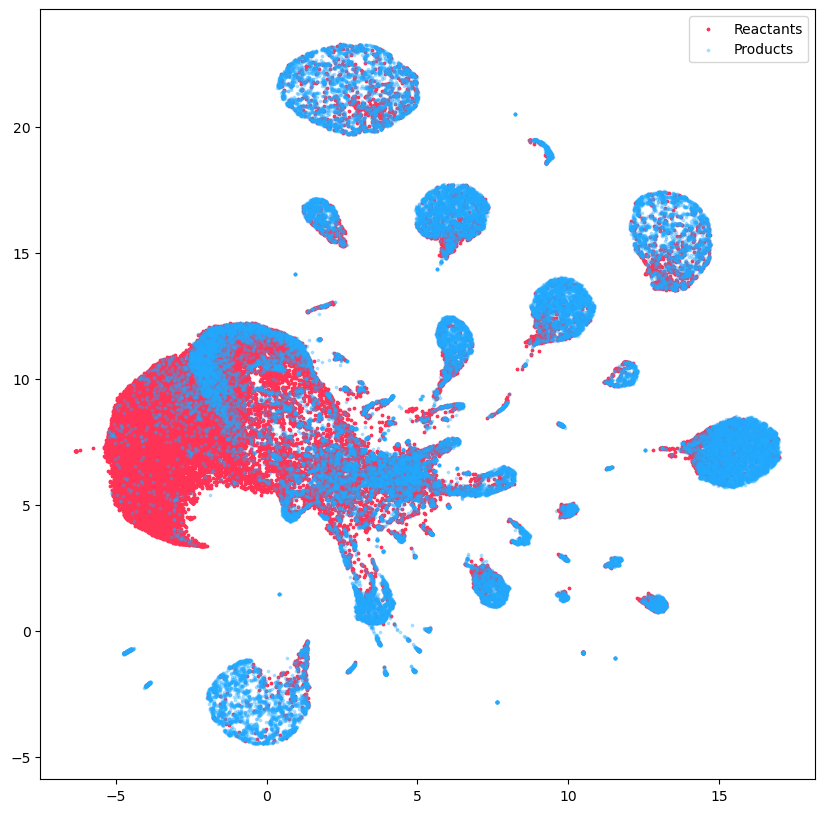

In [20]:
plt.figure(figsize=(10, 10))
plt.scatter(molecule_umap[:len(reactant_embs), 0], molecule_umap[:len(reactant_embs), 1], color='#FF3355', s=3, alpha=1)
plt.scatter(molecule_umap[len(reactant_embs):, 0], molecule_umap[len(reactant_embs):, 1], color='#22AAFF', s=3, alpha=0.3)
plt.legend(['Reactants', 'Products'])
plt.savefig('output/molecule_umap.png')
plt.show()

In [36]:
# Sample two molecules close to 0, 5
from scipy.spatial.distance import cdist
dist = cdist(molecule_umap, np.array([[-5, 5]]))
idx0 = np.argsort(dist, axis=0)[0][0]
idx1 = np.argsort(dist, axis=0)[1][0]
molecule0 = unique_molecules_lst[idx0]
molecule1 = unique_molecules_lst[idx1]
print(f'{molecule0}.{molecule1}')

CCn1cc(C(=O)O)c(=O)c2c(F)c(F)c(F)c(F)c21.Nc1cc(N)cc(C(F)(F)F)c1


In [4]:
import pandas as pd
# Load ../templ_rel/data/raw_train.csv
df = pd.read_csv('../templ_rel/data/raw_train.csv')
classes = []
for i, row in df.iterrows():
    classes.append(row['class'])

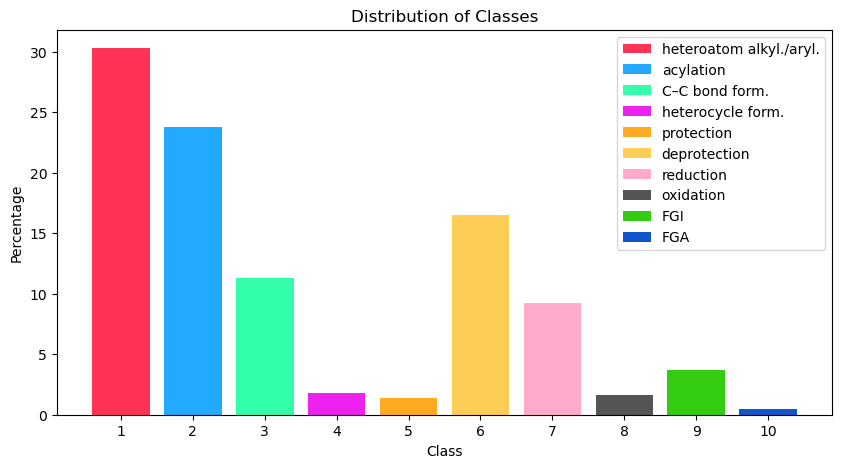

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Color palette
colors = list(class2color.values())

# Assuming 'classes' is a list or array of class values
class_counts = {}
for class_value in classes:
    if class_value in class_counts:
        class_counts[class_value] += 1
    else:
        class_counts[class_value] = 1

# Sort the class counts by class value
sorted_class_counts = sorted(class_counts.items())

# Extract class values and counts into separate lists
class_values = [x[0] for x in sorted_class_counts]
counts = [x[1] for x in sorted_class_counts]

# Calculate the percentage of each class
total = sum(counts)
percentages = [(count / total) * 100 for count in counts]

# Class names
class_names = [
    'heteroatom alkyl./aryl.',
    'acylation',
    'C–C bond form.',
    'heterocycle form.',
    'protection',
    'deprotection',
    'reduction',
    'oxidation',
    'FGI',
    'FGA'
]

# Plot bar chart
plt.figure(figsize=(10, 5))
bar_colors = [colors[i % len(colors)] for i in range(len(class_values))]
bars = plt.bar(class_values, percentages, color=bar_colors)

# Create a custom legend
legend_labels = [class_names[i-1] for i in class_values]
plt.legend([bar for bar in bars], legend_labels, loc='best')

plt.xlabel('Class')
plt.ylabel('Percentage')
plt.title('Distribution of Classes')
plt.xticks(class_values)  # Set x-tick labels to class values

plt.savefig('output/class_distribution.svg', format='svg')
plt.show()